# Processing steps for SNR observed in PN Large Window mode

In [1]:
import os
import subprocess
import sys
import glob
import logging

import numpy as np

from astropy.io import fits
from astropy.stats import mad_std

%matplotlib inline
import matplotlib.pylab as plt

In [2]:
def run_command(command,verbose=True):
    #
    # Execute a shell command with the stdout and stderr being redirected to a log file 
    #
    try:
        result = subprocess.run(command, shell=True,stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
        retcode=result.returncode
        if retcode < 0:
            if (verbose):
                print(f"Execution of {command} was terminated by signal", -retcode, file=sys.stderr)
            logging.warning("Execution of {} was terminated by signal: {} \n {}".format(command,-retcode,result.stdout.decode()))
        else:
            if (verbose):
                print(f"Execution of {command} returned", retcode, file=sys.stderr)
            logging.info("Execution of {} returned {}, \n {}".format(command,retcode,result.stdout.decode()))
    except OSError as e:
        print(f"Execution of {command} failed:", e, file=sys.stderr)
        logging.error("Execution of {} failed: {}".format(command,e))
    return retcode

## Setting up XMM-SAS

For some reason, running the ipython magic command `!. /home/xcaldata/setsas_161.sh`, does not propagate to the session, i.e. although it prints out that SAS is set up, it is not available after the execution of the shell command. So, I have to do it manually, by setting some environment variables.

The last line in the next cell, `!sasversion` should work.

In [3]:
#
# set up XMM-SAS
#
# the current one is 18.0 ==> /home/xcaldata/setsas_180.sh
# tests with XMM-SAS 16.1 for the arfgen
#!. /home/xcaldata/setsas_161.sh
#
sas_dir = "/sas/Linux/RHEL_6.9Workstation/64/sas18_0_0"
#sas_dir = "/sas/Linux/RHEL_6.9Workstation/64/sas16_1_0"
os.environ["SAS_DIR"]= sas_dir
os.environ["SAS_PATH"]=os.environ["SAS_DIR"]
os.environ["SAS_VERBOSITY"]="4"
os.environ["SAS_SUPPRESS_WARNING"]="1"
path = os.environ["PATH"]
os.environ["PATH"] = f"{sas_dir}/bin:{sas_dir}/binextra:{path}"
ld_path = os.environ["LD_LIBRARY_PATH"]
lib_path = f"{sas_dir}/lib:{sas_dir}/libextra:{sas_dir}/libsys:{ld_path}"
os.environ["LD_LIBRARY_PATH"] = lib_path
#
# check
#print ("PATH = ",os.environ["PATH"])
#print ("LF_LIBRARY_PATH = ",os.environ["LD_LIBRARY_PATH"])
#for ikey in os.environ.keys():
#    if ('SAS' in ikey):
#        print (ikey," = ",os.environ[ikey])
!sasversion

sasversion:- Executing (routine): sasversion  -w 1 -V 4
sasversion:- sasversion (sasversion-1.3)  [xmmsas_20190531_1155-18.0.0] started:  2019-07-09T08:55:09.000
sasversion:- XMM-Newton SAS release and build information:

SAS release: xmmsas_20190531_1155-18.0.0
Compiled on: Sun Jun  2 14:11:08 CEST 2019
Compiled by: sasbuild@sasbld01n.net4.lan
Platform   : RHEL6.8 64

SAS-related environment variables that are set:

SAS_DIR = /sas/Linux/RHEL_6.9Workstation/64/sas18_0_0
SAS_PATH = /sas/Linux/RHEL_6.9Workstation/64/sas18_0_0
SAS_CCFPATH = /xdata/ccf/pub

sasversion:- sasversion (sasversion-1.3)  [xmmsas_20190531_1155-18.0.0] ended:    2019-07-09T08:55:09.000


## Processing of a target

Next cell sets up the target name, the XMM `OBS_ID` and the different paths. I usually keep the following structure in the `root_dir`:
```
<target>
   <OBS_ID 1>
       <proc>
   <OBS_ID 2>
       <proc>
   ...
```
where in folders `<OBS_ID>` I keep the ODF files and the CCF file. While in `<proc>` I keep the processing products, like event lists, images etc. The spectral extraction regions are also kept in `<proc>` folder.

For processing with different versions of SAS or calibration, I use different names for the `<proc>` folders.

In [4]:
#
# set up the paths, the target and the OBS_ID
#
root_dir = "/xdata/xcaldata/XMM/IVAN/PN_LW/sources"
#root_dir = "/lhome/ivaltchanov/XMM-clusters"
target="Kepler"
obsid="0084100101"
#target="CasA_S"
#obsid="0110010201"
#target="PuppisA"
#obsid="0150150301"
#target="A2029"
#obsid="0551780301"
#target="A3571"
#obsid="0086950201"
#target="Coma"
#obsid="0300530101"

# the output processing is in folder proc_161
pps="proc_18"
odf_dir = f"{root_dir}/{target}/{obsid}"
#
if (not os.path.isdir(odf_dir)):
    print (f"{odf_dir} does not exist. Cannot continue.")
    raise FileNotFoundError
else:
    print (f"Found ODF folder: {odf_dir}.")
#
pps_dir = f"{root_dir}/{target}/{obsid}/{pps}"
if (not os.path.isdir(pps_dir)):
    print (f"{pps_dir} does not exist. Cannot continue.")
    raise FileNotFoundError
else:
    print (f"Will use {pps_dir} for the event lists and the output products.")
#
ccf_file = f"{pps_dir}/ccf.cif"
if (not os.path.isfile(ccf_file)):
    print (f"CCF file {ccf_file} not found. Cannot continue.")
    raise FileNotFoundError
else:
    print (f"Will use {ccf_file} CCF file.")

os.environ['SAS_ODF'] = odf_dir
os.environ['SAS_CCFPATH'] = '/ccf/pub'
os.environ['SAS_CCF'] = f"{pps_dir}/ccf.cif"
#
# logging to file
#
logfile_name = f'{pps_dir}/{target}_{obsid}_{pps}_specext.log'
logging.basicConfig(level=logging.DEBUG,
                    format='%(asctime)s %(levelname)s %(message)s',
                    filename=logfile_name,
                    filemode='w')
os.chdir(pps_dir)

Found ODF folder: /xdata/xcaldata/XMM/IVAN/PN_LW/sources/Kepler/0084100101.
Will use /xdata/xcaldata/XMM/IVAN/PN_LW/sources/Kepler/0084100101/proc_18 for the event lists and the output products.
Will use /xdata/xcaldata/XMM/IVAN/PN_LW/sources/Kepler/0084100101/proc_18/ccf.cif CCF file.


In [5]:
#
# check for consistency the SAS version
#
status = run_command('sasversion')
if (status != 0):
    print ('XMM-SAS is not available. Cannot continue.')
    raise Exception
else:
    print ("Found XMM-SAS.")
#

Found XMM-SAS.


Execution of sasversion returned 0


### Region files

The region in DETXY will be stored in a dict with the instrument

In [19]:
src_reg = {}
for inst in ["mos1","mos2","pn"]:
    src_file = f'kepler_{inst}_polygon_detxy_test3.reg'
    if (not os.path.isfile(src_file)):
        print (f"Cannot find region file {src_file}")
        raise FileNotFoundError
    #
    with open(src_file,'r') as reg:
        lines = reg.readlines()
    for xline in lines:
        if ('circle' in xline):
        #if ('polygon' in xline):
            src_reg[inst] = xline
            break
    print (inst,src_reg[inst])

mos1 circle(25012.415,23803.56,1200)

mos2 circle(25012.415,23803.56,1200)

pn circle(25012.415,23803.56,1200)



## Extract filtered event lists for the region

This filtered event list will be used to assess the pile up

In [20]:
#
for inst in ["mos1","mos2","pn"]:
    evlist = f'{inst}_evlist_clean.fits'
    out_name = f'{target}_{obsid}_{inst}_pileup_test3.fits'
    ev_command = f"evselect table={evlist} withfilteredset=yes filteredset={out_name}" + \
    f" keepfilteroutput=yes expression='((X,Y) IN {src_reg[inst]})'"
    status = run_command(ev_command)
    if (status != 0):
        raise Exception
#

Execution of evselect table=mos1_evlist_clean.fits withfilteredset=yes filteredset=Kepler_0084100101_mos1_pileup_test3.fits keepfilteroutput=yes expression='((X,Y) IN circle(25012.415,23803.56,1200)
)' returned 0
Execution of evselect table=mos2_evlist_clean.fits withfilteredset=yes filteredset=Kepler_0084100101_mos2_pileup_test3.fits keepfilteroutput=yes expression='((X,Y) IN circle(25012.415,23803.56,1200)
)' returned 0
Execution of evselect table=pn_evlist_clean.fits withfilteredset=yes filteredset=Kepler_0084100101_pn_pileup_test3.fits keepfilteroutput=yes expression='((X,Y) IN circle(25012.415,23803.56,1200)
)' returned 0


## Extract source spectrum in user provided region


In [11]:
#
for inst in ["mos1","mos2","pn"]:
    evlist = f'{inst}_evlist_clean.fits'
    spec_name = f'{target}_{obsid}_{inst}_spectrum_src_user.fits'
    #
    if ('pn' in inst):
        spec_chan_max = 20479
        expr1 = "(FLAG==0) && (PATTERN<=4)"
    else:
        spec_chan_max = 11999
        expr1 = "#XMMEA_EM && (PATTERN<=12)"
    #
    ev_command = f"evselect table={evlist} withspectrumset=yes spectrumset={spec_name}" +  \
    f" energycolumn=PI spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax={spec_chan_max}" +  \
    f" expression='{expr1} && ((X,Y) IN {src_reg[inst]})'"
    status = run_command(ev_command)
    if (status != 0):
        raise Exception
    #
    # Now backscale the source spectrum
    #
    print ("*** Backscale the source spectrum")
    xcommand = f"backscale spectrumset={spec_name} badpixlocation={evlist}"
    status = run_command(xcommand)
    if (status != 0):
        raise Exception

Execution of evselect table=mos1_evlist_clean.fits withspectrumset=yes spectrumset=Kepler_0084100101_mos1_spectrum_src_user.fits energycolumn=PI spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax=11999 expression='#XMMEA_EM && (PATTERN<=12) && ((X,Y) IN polygon(23258.483,25164.846,23779.635,25741.037,24507.264,26071.353,26193.83,26083.972,27085.513,24451.599,26509.326,24163.503,25768.352,24972.871,24615.942,25055.159,23491.181,24286.934)
)' returned 0


*** Backscale the source spectrum


Execution of backscale spectrumset=Kepler_0084100101_mos1_spectrum_src_user.fits badpixlocation=mos1_evlist_clean.fits returned 0
Execution of evselect table=mos2_evlist_clean.fits withspectrumset=yes spectrumset=Kepler_0084100101_mos2_spectrum_src_user.fits energycolumn=PI spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax=11999 expression='#XMMEA_EM && (PATTERN<=12) && ((X,Y) IN polygon(23258.483,25164.846,23779.635,25741.037,24507.264,26071.353,26193.83,26083.972,27085.513,24451.599,26509.326,24163.503,25768.352,24972.871,24615.942,25055.159,23491.181,24286.934)
)' returned 0


*** Backscale the source spectrum


Execution of backscale spectrumset=Kepler_0084100101_mos2_spectrum_src_user.fits badpixlocation=mos2_evlist_clean.fits returned 0
Execution of evselect table=pn_evlist_clean.fits withspectrumset=yes spectrumset=Kepler_0084100101_pn_spectrum_src_user.fits energycolumn=PI spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax=20479 expression='(FLAG==0) && (PATTERN<=4) && ((X,Y) IN polygon(23258.171,25164.879,23779.431,25741.013,24507.58,26071.356,26193.696,26083.958,27085.334,24451.588,26509.204,24163.52,25768.46,24972.845,24616.196,25055.145,23491.371,24286.965)
)' returned 0


*** Backscale the source spectrum


Execution of backscale spectrumset=Kepler_0084100101_pn_spectrum_src_user.fits badpixlocation=pn_evlist_clean.fits returned 0


## Plotting section

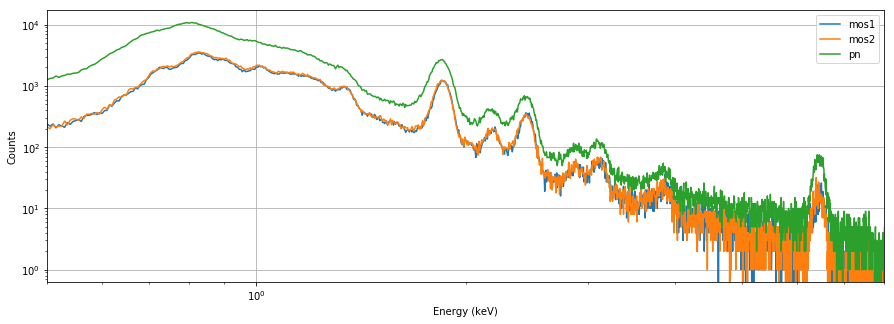

In [13]:
os.chdir(pps_dir)
fig = plt.figure(figsize=(15,5))
ax = fig.subplots()

for inst in ["mos1","mos2","pn"]:
    spec_name = f'{target}_{obsid}_{inst}_spectrum_src_user.fits'
    hdu = fits.open(spec_name)
    qrev = hdu[0].header['REVOLUT']
    qsubmode = hdu[0].header['SUBMODE']
    qfilt = hdu[0].header['FILTER']
    #plot_title = f"Target: {target}, {qrev}_{obsid}, {qsubmode}, {qfilt}"
    #
    spec = hdu['SPECTRUM']
    binsize = spec.header['SPECDELT']
    x = spec.data['CHANNEL']*binsize/1000.0
    y = spec.data['COUNTS']
    xlims  = (0.5, 8.0)
    #
    ax.loglog(x,y,label=f'{inst}')
    #ax.step(a[1][1:],a[0],color='red')
    #ax.step(x,y,color='red')
ax.set_xlim(xlims)
#ax.set_ylim((1.0e-2,))
ax.set_xlabel("Energy (keV)")
ax.set_ylabel("Counts")
#ax.set_title(plot_title)
ax.grid()
ax.legend()
#plt.savefig(f"{pps_dir}/{target}_{obsid}_src_poly.png",dpi=100)
#plt.show()
#plt.close();

## MOS diagonal events

To check the pile up spatial distribution with diagonal events (`PATTERN in [26:29]`)

In [22]:
bin_size = 80
#
for inst in ['mos1','mos2']:
    evlist = f'{inst}_evlist_clean.fits'
    if (not os.path.isfile(evlist)):
        print(f"Cannot find cleaned event lists for {inst}. Image will not be generated.")
        continue
    image_name = f'{inst}_image_patt_26_29.fits'
    #
    expr = f'PATTERN <= 29 && PATTERN >= 26'
    #    
    ev_command = f'evselect table={evlist} xcolumn=X ycolumn=Y imagebinning=binSize' +  \
         f' ximagebinsize={bin_size} yimagebinsize={bin_size}' + \
         f' expression=\'{expr}\'' +  \
         f' withimageset=true imageset={image_name}'
    status = run_command(ev_command)
    if (status != 0):
        raise Exception

Execution of evselect table=mos1_evlist_clean.fits xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 yimagebinsize=80 expression='PATTERN <= 29 && PATTERN >= 26' withimageset=true imageset=mos1_image_patt_26_29.fits returned 0
Execution of evselect table=mos2_evlist_clean.fits xcolumn=X ycolumn=Y imagebinning=binSize ximagebinsize=80 yimagebinsize=80 expression='PATTERN <= 29 && PATTERN >= 26' withimageset=true imageset=mos2_image_patt_26_29.fits returned 0


In [ ]:
print ("*** All done.")
logging.info ("*** All done.")